In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import datetime

# Note: used Data Color Picker from learnui.design for color scheme

# Import the data
JC240_data = pd.read_csv('JC240_data.csv')
JC241_data = pd.read_csv('JC241_data.csv')

In [2]:
# Calculate accuracy for over all sessions for a given animal
def get_accuracy(JCxxx):
    data_JCxxx = str(JCxxx) + "_data" # concatenate strings
    data_JCxxx = globals()[data_JCxxx] # convert string to variable
    bysession_JCxxx = data_JCxxx.groupby("Session_ID")
    sessions = bysession_JCxxx["Session_ID"].unique().to_numpy(dtype=int)
    accuracy = np.zeros(len(sessions))
    for session in range(1, len(sessions)+1):
        accuracy[session-1] = round(bysession_JCxxx.get_group(session)["CorrectBool"].sum() / bysession_JCxxx.get_group(session).count()[0]*100, 0)
    return accuracy, sessions
    
accuracy_JC240, sessions_JC240 = get_accuracy("JC240")
accuracy_JC241, sessions_JC241 = get_accuracy("JC241")

In [3]:
# Calculate arm choice by session
def get_arm_choice(JCxxx):
    data_JCxxx = str(JCxxx) + "_data" # get data
    data_JCxxx = globals()[data_JCxxx] # turn into variable
    bysession_JCxxx = data_JCxxx.groupby("Session_ID") # group by session
    sessions = bysession_JCxxx["Session_ID"].unique() # list sessions
    arms = np.array([3, 7]) # list arms of interest
    num_arms = len(arms) # count arms
    arm_choice = np.zeros((len(sessions), num_arms+1)) # make a vector that will hold arm choice for each session
                                                        # and add another column for other arms
    num_trials = np.zeros(len(sessions))
    for session in range(1, len(sessions)+1): # iterate over sessions, starting at 1 instead of 0
        num_trials[session-1] = bysession_JCxxx.get_group(session).count()[0] # count number of trials per session
        for arm in range(num_arms): # iterate over arms by indexing numpy array
            this_session = bysession_JCxxx.get_group(session)
            choices_bool = this_session["Arm"]==(arms[arm]) # Boolean of whether arm was chosen
            count = len(choices_bool[choices_bool==True])
            arm_choice[session-1][arm] = count
        arm_choice[session-1][-1] = num_trials[session-1] - arm_choice[session-1][0] - arm_choice[session-1][1]
                                    # for last column subtract arms of interest from total trials
    arm_choice = arm_choice / num_trials[:,None] # express arm choice as a proportion of total trials
    return num_trials, arm_choice

num_trials_JC240, arm_choice_JC240 = get_arm_choice("JC240")
num_trials_JC241, arm_choice_JC241 = get_arm_choice("JC241")

In [4]:
# Compute statistics
accuracy_mean = np.mean([accuracy_JC240[0:8], accuracy_JC241[0:8]], axis=0)
accuracy_sem = stats.sem([accuracy_JC240[0:8], accuracy_JC241[0:8]], axis=0)

arm_choice_mean = np.mean([arm_choice_JC240[0:8], arm_choice_JC241[0:8]], axis=0)
arm_choice_sem = stats.sem([arm_choice_JC240[0:8], arm_choice_JC241[0:8]], axis=0)

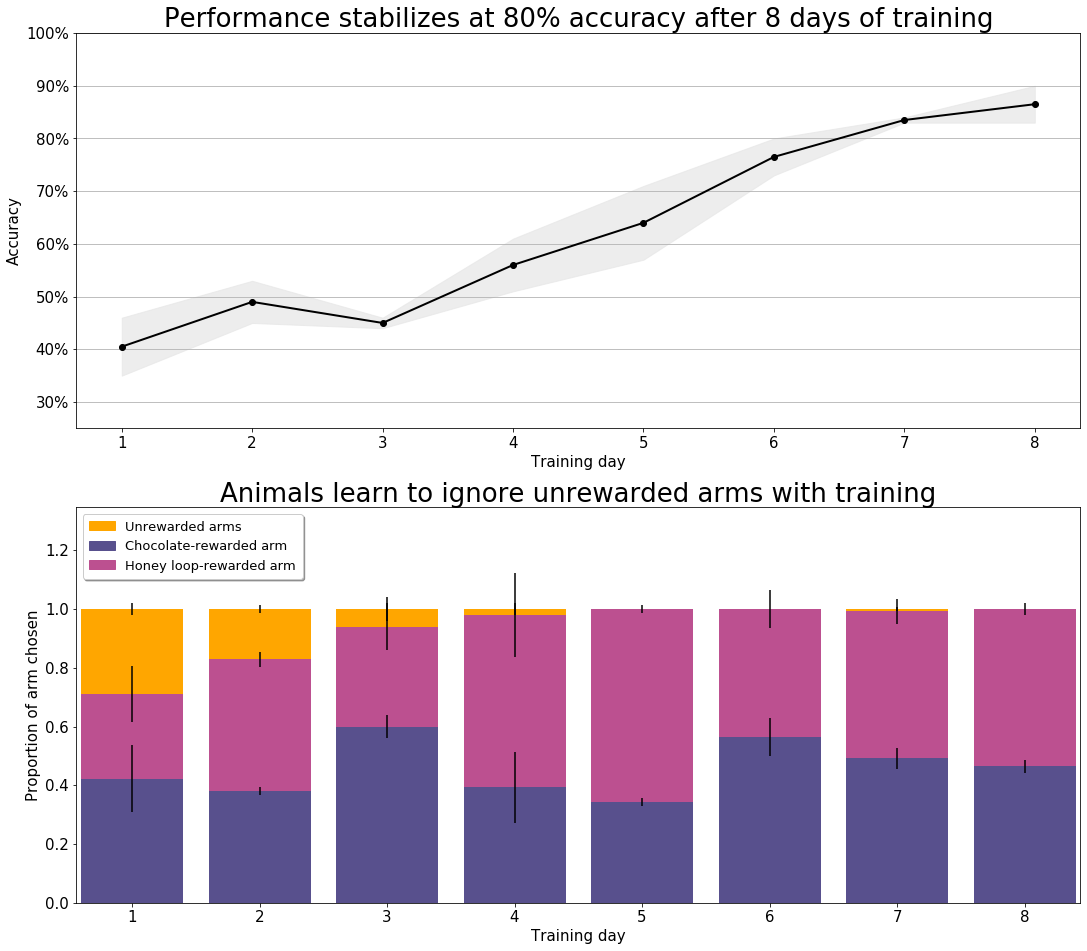

In [52]:
# Plot accuracy and arm choice before third flavor introduced
fig = plt.figure(figsize=(18,16))
# plt.suptitle("Performance stabilizes at 80% accuracy after 8 days of training", fontsize = 26, y=0.93)
plt.tight_layout()

# Accuracy
ax1 = fig.add_subplot(211)
# ax1.plot(sessions_JC240[0:8], accuracy_JC240[0:8], color='0.9', linewidth=2) # JC240 accuracy plotted individually #00429d
# ax1.plot(sessions_JC241[0:8], accuracy_JC241[0:8], color='0.9', linewidth=2) # JC241 accuracy plotted individually #1b9e77
# testing new fork for datavis class
ax1.plot(sessions_JC240[0:8], accuracy_mean, color='k', linewidth=2, marker='o') # decided to plot mean instead
# ax1.errorbar(sessions_JC240[0:8], accuracy_mean, yerr=accuracy_sem) # error bars
ax1.fill_between(sessions_JC240[0:8], accuracy_mean-accuracy_sem, accuracy_mean+accuracy_sem, color='0.9', alpha=0.7) # standard error shading
ax1.set_title("Performance stabilizes at 80% accuracy after 8 days of training", fontsize=26)
ax1.set_xlabel("Training day", fontsize=15)
ax1.tick_params(labelsize=15)
ax1.set_ylabel("Accuracy", fontsize=15)
ax1.xaxis.set_major_locator(mtick.MultipleLocator(1))
# ax1.yaxis.set_major_formatter('{x:,.0f}%') # this doesn't run on laptop
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%')) # runs on laptop
ax1.set_ylim(25,100)
ax1.yaxis.grid()


# Arm choice
ax2 = fig.add_subplot(212)
ax2.bar(sessions_JC240[0:8], arm_choice_mean[0:8,0], color='#58508d', yerr = arm_choice_sem[:,0])
ax2.bar(sessions_JC240[0:8], arm_choice_mean[0:8,1], color='#bc5090', yerr = arm_choice_sem[:,1], bottom=arm_choice_mean[0:8,0]) # arm 7
ax2.bar(sessions_JC240[0:8], arm_choice_mean[0:8,2], color='#ffa600', yerr = arm_choice_sem[:,2], bottom=arm_choice_mean[0:8,0]+arm_choice_mean[0:8,1]) # other arms
ax2.set_title("Animals learn to ignore unrewarded arms with training", fontsize=26)
ax2.set_xlabel("Training day", fontsize=15)
ax2.set_ylabel("Proportion of arm chosen", fontsize=15)
ax2.tick_params(labelsize=15)
ax2.yaxis.set_ticks(np.arange(0,1.4,0.2))
# legend
chocolate_arm = mpatches.Patch(color='#58508d', label = 'Chocolate-rewarded arm')
honey_arm = mpatches.Patch(color='#bc5090', label = 'Honey loop-rewarded arm')
other_arm = mpatches.Patch(color='#ffa600', label = 'Unrewarded arms')
ax2.margins(x=0.005, y=0.2) # margins
ax2.legend(handles=[other_arm, chocolate_arm, honey_arm], loc=2, fontsize=13, fancybox=True, shadow=1, borderpad=0.5)


plt.show()
timestamp = datetime.datetime.today().strftime("%Y-%m-%d %H%M%S")
# plt.savefig("Accuracy and arm choice "+timestamp+".pdf")